In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
import seaborn as sns

### Đọc toàn bộ dữ liệu

In [2]:
dataset = pd.read_pickle('data/train/cars.pkl')
dataset["Tỉnh"] = np.where(dataset["Tỉnh"].isin(["Hà Nội", "TP HCM"]), dataset["Tỉnh"], "other")

dataset["Năm sản xuất"] = 2024 - dataset["Năm sản xuất"]
dataset.rename(columns={"Năm sản xuất": "Tuối xe"}, inplace=True)
print(dataset.shape)
dataset.head()

(25582, 15)


,Tên hãng xe,Tuối xe,Tỉnh,Số Km đã đi,Xuất xứ,Kiểu dáng,Hộp số,Màu ngoại thất,Màu nội thất,Số chỗ ngồi,Số cửa,Dẫn động,Loại động cơ,Dung tích,Giá
0,audi,4,TP HCM,30.0,Nhập khẩu,Sedan,Số tự động,Đen,Đen,5,4,AWD,Xăng,3.0,2950.0
1,audi,10,Hà Nội,94.0,Nhập khẩu,Sedan,Số tự động,Xanh,Nâu,5,4,FWD,Xăng,2.0,560.0
2,audi,8,TP HCM,50.0,Nhập khẩu,Sedan,Số tự động,Đen,Đen,5,4,FWD,Xăng,2.0,690.0
3,audi,8,Hà Nội,76.0,Nhập khẩu,Crossover,Số tự động,Xanh,Đen,5,5,AWD,Xăng,2.0,699.0
4,audi,8,Hà Nội,90.0,Nhập khẩu,SUV,Số tự động,Trắng,Kem,5,5,AWD,Xăng,2.0,739.0


Loại outliers 

In [3]:
import pandas as pd
from scipy import stats

def remove_outliers(dataset):
    # Xác định các cột số
    numeric_columns = ['Giá', 'Số Km đã đi']
    
    # Loại bỏ outliers bằng phương pháp Z-score
    for col in numeric_columns:
        z_scores = stats.zscore(dataset[col])
        abs_z_scores = abs(z_scores)
        filtered_entries = (abs_z_scores < 3)
        dataset = dataset[filtered_entries]
    
    print("Dataset shape after removing outliers:", dataset.shape)
    
    return dataset

# Sử dụng hàm để loại bỏ outliers
dataset = remove_outliers(dataset)

# Hiển thị thông tin dataset sau khi xử lý
print(dataset.shape)
print(dataset.head())

Dataset shape after removing outliers: (25041, 15)
(25041, 15)
  Tên hãng xe  Tuối xe    Tỉnh  Số Km đã đi    Xuất xứ  Kiểu dáng      Hộp số  \
0        audi        4  TP HCM         30.0  Nhập khẩu      Sedan  Số tự động   
1        audi       10  Hà Nội         94.0  Nhập khẩu      Sedan  Số tự động   
2        audi        8  TP HCM         50.0  Nhập khẩu      Sedan  Số tự động   
3        audi        8  Hà Nội         76.0  Nhập khẩu  Crossover  Số tự động   
4        audi        8  Hà Nội         90.0  Nhập khẩu        SUV  Số tự động   

  Màu ngoại thất Màu nội thất  Số chỗ ngồi  Số cửa Dẫn động Loại động cơ  \
0            Đen          Đen            5       4      AWD         Xăng   
1           Xanh          Nâu            5       4      FWD         Xăng   
2            Đen          Đen            5       4      FWD         Xăng   
3           Xanh          Đen            5       5      AWD         Xăng   
4          Trắng          Kem            5       5      AWD         Xă

In [4]:
X = dataset.drop(columns=['Giá'], axis=1)
y = dataset['Giá']

Khai báo seed, test size để chia dữ liệu huấn luyện, kiểm thử giống nhau

In [5]:
SPLIT_SEED = 99
TEST_SIZE = .25

### Thiết kế hàm đánh giá mô hình dự đoán giá trị

Sử dụng 3 metrics chính để đánh giá sự hiệu quả của mô hình dự đoán:
- Mean Squared Error (MSE): Trung bình bình phương sai số, MSE càng nhỏ, mô hình càng tốt
- Mean Absolute Error (MAE): Trung bình giá trị tuyệt đối sai số. MAE càng nhỏ, mô hình càng tốt
- $R^2$ Score: Hệ số xác định, thể hiện mức độ phù hợp của mô hình với dữ liệu, giá trị nằm trong khoảng (0, 1)
$R^2 = 1 - \frac{SSR}{TSS}$ với SSR(sum of squared residuals): tổng bình phương sai số, và TSS(total sum of squares): tổng bình phương sự khác biệt giá trị thực tế và giá trị trung bình, $R^2 Score$ càng gần 1, thì mô hình giải thích tốt sự biến đổi trong dữ liệu

In [6]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error

def evaluate(y_pred, y_test):
    np.set_printoptions(precision=0)
    values = np.concatenate((y_pred.reshape(-1, 1), y_test.reshape(-1, 1)), 1)
    print(values)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    max_err = max_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R^2 Score: {r2}")
    print(f"Max Error: {max_err}")

    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
    plt.show()
    return mse, mae, r2

### Thiết kế baseline bằng mô hình Linear Regression đơn giản

Mã hóa dữ liệu danh mục bằng LabelEncoder

Chia dữ liệu huấn luyện, kiểm thử

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Identify categorical columns
categorical_cols = [
        "Tên hãng xe", "Tỉnh", "Xuất xứ", "Kiểu dáng", "Hộp số", 
        "Màu ngoại thất", "Màu nội thất", "Dẫn động", "Loại động cơ"]

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
OH_X = OH_encoder.fit_transform(dataset[categorical_cols])

# One-hot encoding removed index; put it back
OH_X_df = pd.DataFrame.sparse.from_spmatrix(OH_X)
OH_X_df.index = dataset.index

# Remove categorical columns (will replace with one-hot encoding)
num_X = dataset.drop(categorical_cols, axis=1)

# Concatenate the numerical and one-hot encoded categorical columns
dataset_encoded = pd.concat([num_X, OH_X_df], axis=1)
# Chuyển đổi tất cả các tên cột thành chuỗi
dataset_encoded.columns = dataset_encoded.columns.astype(str)
# Chia DataFrame thành tập dữ liệu huấn luyện và tập dữ liệu kiểm tra
train_data, test_data = train_test_split(dataset_encoded, test_size=0.2, random_state=SPLIT_SEED)

# Separate target from predictors
y_train = train_data["Giá"]
X_train = train_data.drop(['Giá'], axis=1)
y_test = test_data['Giá']
X_test = test_data.drop(['Giá'], axis=1)
print(X_train.columns, X_test.columns)



Index(['Tuối xe', 'Số Km đã đi', 'Số chỗ ngồi', 'Số cửa', 'Dung tích', '0',
       '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',
       '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49',
       '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61',
       '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73',
       '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85'],
      dtype='object') Index(['Tuối xe', 'Số Km đã đi', 'Số chỗ ngồi', 'Số cửa', 'Dung tích', '0',
       '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',
       '38', '39', '40', '41', '42', '43'

In [8]:
X_train.shape
y_train.shape


(20032,)

In [9]:
X_test.shape
y_test.shape

(5009,)

Fit mô hình Linear Regression

[[1616. 1069.]
 [1968. 2549.]
 [ 825.  979.]
 ...
 [1257. 1050.]
 [2906. 4286.]
 [ 912.  822.]]
Mean Squared Error: 307798.1437416114
Mean Absolute Error: 358.0223830656541
R^2 Score: 0.7093578525555866
Max Error: 3933.289040395607


/home/admin/miniconda3/envs/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/admin/miniconda3/envs/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


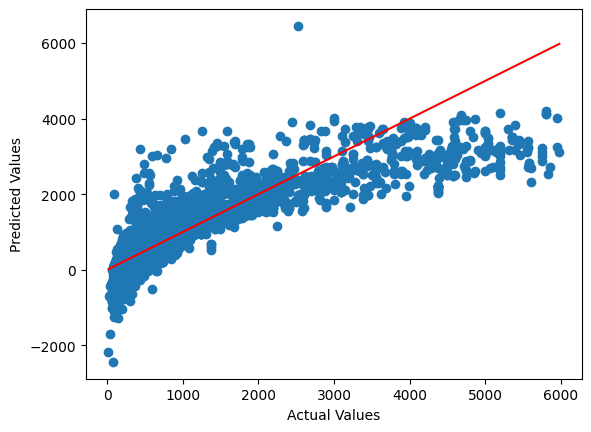

In [10]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

## Ridge Regression (L2 Regularization)

/home/admin/miniconda3/envs/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[[1616. 1069.]
 [1969. 2549.]
 [ 825.  979.]
 ...
 [1257. 1050.]
 [2906. 4286.]
 [ 912.  822.]]
Mean Squared Error: 307791.9342909812
Mean Absolute Error: 358.0277540285595
R^2 Score: 0.7093637159050001
Max Error: 3933.701327402029


/home/admin/miniconda3/envs/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


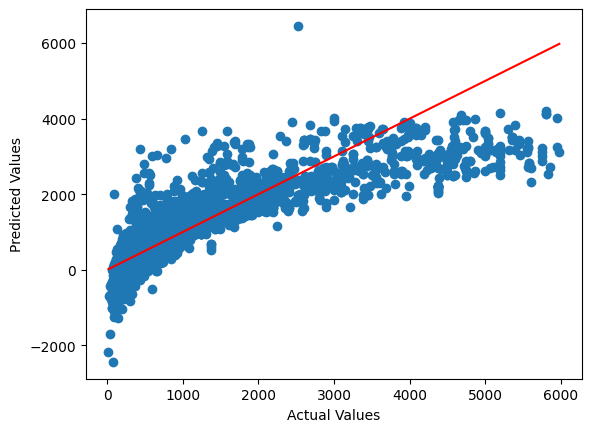

In [11]:
from sklearn.linear_model import Ridge
regressor = Ridge(alpha=0.1)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

## Lasso Regression (L1 Regularization)

/home/admin/miniconda3/envs/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[[1617. 1069.]
 [1967. 2549.]
 [ 824.  979.]
 ...
 [1259. 1050.]
 [2911. 4286.]
 [ 913.  822.]]
Mean Squared Error: 307438.80646215833
Mean Absolute Error: 357.8255838258513
R^2 Score: 0.70969716115988
Max Error: 3938.361631507344


/home/admin/miniconda3/envs/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


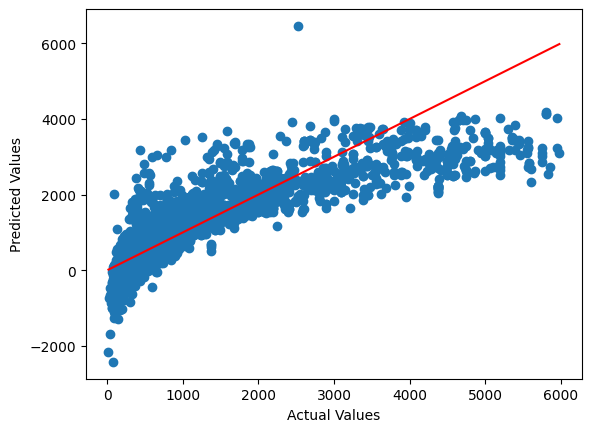

In [12]:
from sklearn.linear_model import Lasso

regressor = Lasso(alpha=0.1)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

## Decision Tree Regression

/home/admin/miniconda3/envs/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[[1135. 1069.]
 [2649. 2549.]
 [ 979.  979.]
 ...
 [1050. 1050.]
 [4286. 4286.]
 [ 772.  822.]]
Mean Squared Error: 33770.10288122917
Mean Absolute Error: 66.59694459493183
R^2 Score: 0.9681121688990475
Max Error: 2509.0


/home/admin/miniconda3/envs/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


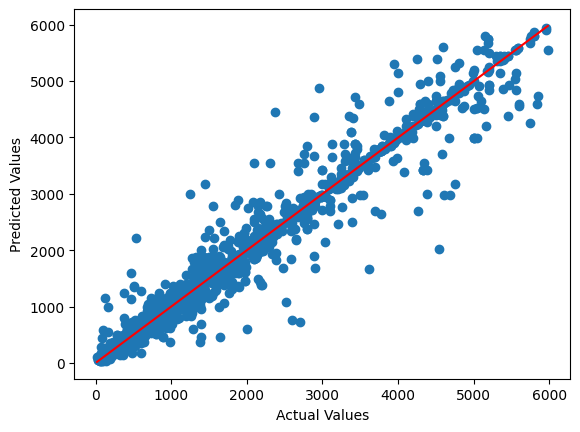

In [13]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

In [14]:
regressor.feature_importances_

array([2.e-01, 7.e-02, 5.e-03, 2.e-03, 2.e-01, 3.e-02, 2.e-03, 1.e-04,
       5.e-03, 8.e-05, 9.e-06, 7.e-04, 2.e-03, 3.e-04, 8.e-06, 1.e-02,
       1.e-03, 4.e-03, 2.e-02, 1.e-04, 3.e-05, 5.e-04, 9.e-06, 1.e-05,
       3.e-04, 7.e-02, 8.e-03, 3.e-05, 1.e-02, 4.e-05, 3.e-04, 1.e-03,
       7.e-04, 9.e-04, 4.e-04, 3.e-02, 9.e-03, 2.e-04, 2.e-04, 2.e-04,
       5.e-03, 1.e-04, 5.e-03, 2.e-03, 4.e-06, 9.e-03, 1.e-05, 5.e-04,
       3.e-04, 1.e-03, 1.e-05, 1.e-05, 8.e-05, 4.e-06, 1.e-05, 1.e-06,
       7.e-05, 4.e-04, 1.e-03, 2.e-06, 3.e-04, 1.e-03, 4.e-04, 3.e-03,
       3.e-04, 3.e-06, 7.e-05, 4.e-05, 6.e-06, 4.e-05, 1.e-07, 1.e-03,
       2.e-05, 2.e-04, 2.e-03, 5.e-06, 1.e-08, 1.e-04, 9.e-06, 9.e-05,
       1.e-03, 6.e-04, 1.e-06, 4.e-03, 3.e-01, 3.e-04, 8.e-04, 3.e-02,
       2.e-04, 7.e-03, 6.e-05])

## Random Forest Regression

/home/admin/miniconda3/envs/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[[1125. 1069.]
 [2221. 2549.]
 [ 893.  979.]
 ...
 [1046. 1050.]
 [4286. 4286.]
 [ 774.  822.]]
Mean Squared Error: 20692.43326638532
Mean Absolute Error: 58.78762771070775
R^2 Score: 0.9804609177713524
Max Error: 1729.62


/home/admin/miniconda3/envs/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


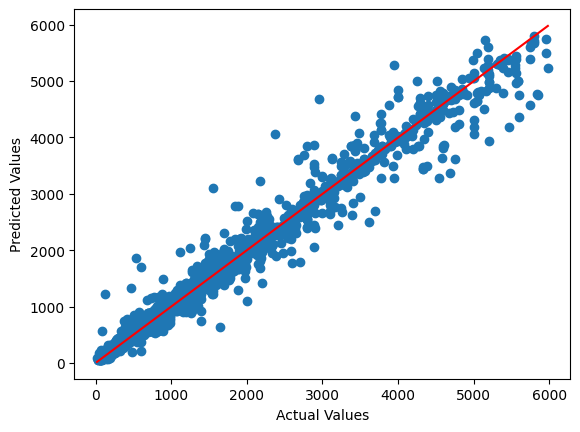

In [15]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

Tối ưu hóa Random Forest bằng GridSearch

In [16]:
# from sklearn.model_selection import GridSearchCV
# params = {
#     "criterion": ["squared_error", "friedman_mse", "poisson"],

# }
# regressor = RandomForestRegressor(random_state=1, n_estimators=100)

# optimizer = GridSearchCV(regressor, params, cv=5, n_jobs=-1, verbose=2)
# optimizer.fit(X_train.values, y_train.values)
# y_pred = optimizer.predict(X_test)
# _ = evaluate(y_pred, y_test.values)

In [17]:
# regressor = RandomForestRegressor(
#     random_state=1,
#     criterion="poisson",
#     n_estimators=100,
#     max_leaf_nodes=16,
#     min_samples_split=10,
#     min_samples_leaf=10,
# )
# regressor.fit(X_train, y_train)

In [18]:
# regressor.feature_importances_

In [19]:
# feature_imp = pd.Series(
#     regressor.feature_importances_, index=X_train.columns
# ).sort_values(ascending=False)
# print(feature_imp)
# sns.barplot(x=feature_imp, y=feature_imp.index)
# # Add labels to your graph
# plt.xlabel("Feature Importance Score")
# plt.ylabel("Features")
# plt.title("Visualizing Important Features")

## K-Nearest Neighbors (KNN)

/home/admin/miniconda3/envs/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/admin/miniconda3/envs/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/admin/miniconda3/envs/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/admin/miniconda3/envs/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[[ 974. 1069.]
 [2136. 2549.]
 [ 822.  979.]
 ...
 [1048. 1050.]
 [4609. 4286.]
 [ 749.  822.]]
Mean Squared Error: 132788.16425434218
Mean Absolute Error: 153.1615092832901
R^2 Score: 0.8746131580101989
Max Error: 4183.25


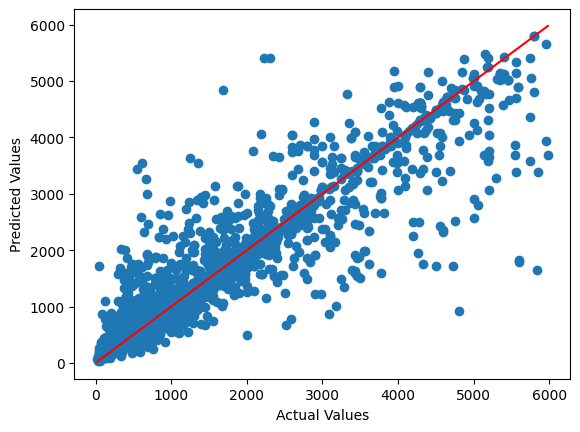

In [20]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

regressor = KNeighborsRegressor(n_neighbors=4)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

## Support Vector Regression

[[ 943. 1069.]
 [ 922. 2549.]
 [ 675.  979.]
 ...
 [ 688. 1050.]
 [1124. 4286.]
 [ 730.  822.]]
Mean Squared Error: 938374.7212273573
Mean Absolute Error: 468.08686496146305
R^2 Score: 0.11392823631183846
Max Error: 5082.64014092805


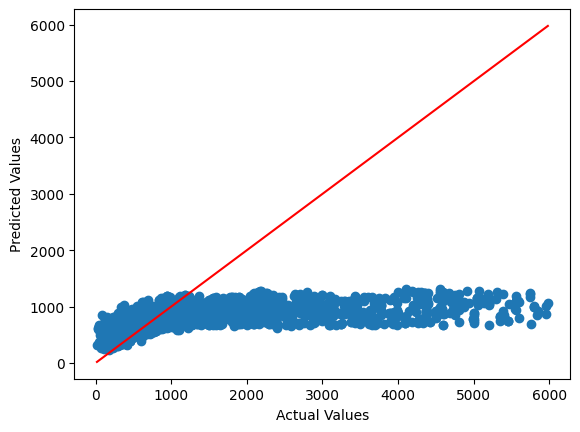

In [21]:
from sklearn.svm import SVR

regressor = SVR(kernel='rbf')
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

## Gradient Boosting Regression

[[1243. 1069.]
 [2024. 2549.]
 [ 861.  979.]
 ...
 [1216. 1050.]
 [4260. 4286.]
 [ 635.  822.]]
Mean Squared Error: 96094.18630145978
Mean Absolute Error: 177.39993024759653
R^2 Score: 0.9092618937720901
Max Error: 2294.6944118153333


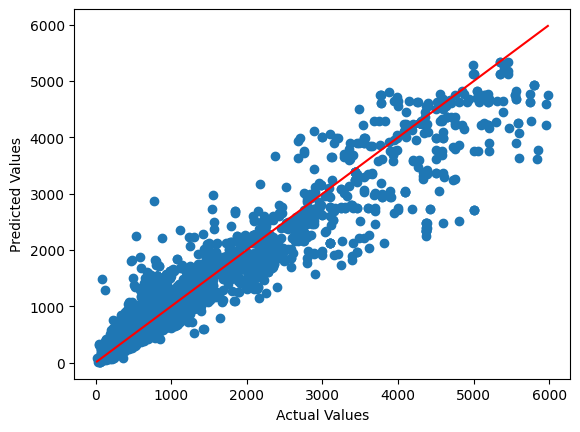

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

### Bagging

[[1123. 1069.]
 [2180. 2549.]
 [ 878.  979.]
 ...
 [1045. 1050.]
 [5154. 4286.]
 [ 773.  822.]]
Mean Squared Error: 28174.292421552676
Mean Absolute Error: 73.20516282440721
R^2 Score: 0.973396081105021
Max Error: 1686.0749999999998


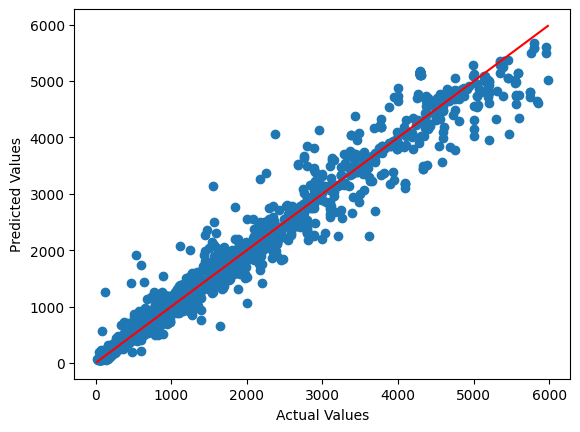

In [23]:
from sklearn.ensemble import BaggingRegressor

regressor = DecisionTreeRegressor()
bagging = BaggingRegressor(estimator=regressor, n_estimators=100, random_state=0)
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)
_ = evaluate(y_pred, y_test.values)